In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
import numpy as np
from rmab.utils import get_results_matching_parameters
from rmab.plots import aggregate_data, aggregate_normalize_data
import seaborn as sns
from rmab.fr_dynamics import get_all_transitions
import random 
import math
from copy import deepcopy
import scipy.stats as stats 
from collections import Counter

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')


In [63]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [5]:
colors_by_method = {}
baseline_methods = ['random','whittle_activity','greedy','mcts','dqn_step','dqn']
whittle_methods = ['linear_whittle','shapley_whittle_custom']
iterative_methods = ['iterative_whittle','shapley_iterative_whittle']
mcts = ['mcts_linear','mcts_shapley']
non_baselines = whittle_methods + iterative_methods
time_shapley_iterative = ["shapley_iterative_whittle_100","shapley_iterative_whittle_10","shapley_iterative_whittle_1"]
time_mcts = ["mcts_shapley_40","mcts_shapley_4"]

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(whittle_methods) + len(iterative_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(mcts)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(non_baselines):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(mcts):
    colors_by_method[m] = wistia[i]
for i,m in enumerate(time_shapley_iterative):
    colors_by_method[m] = (1-(i+1)*0.25)*colors_by_method['shapley_iterative_whittle'] + (i+1)*0.25*np.array([1,1,1,1])
for i,m in enumerate(time_mcts):
    colors_by_method[m] = (1-(i+1)*0.25)*colors_by_method['mcts_shapley'] + (i+1)*0.25*np.array([1,1,1,1])

colors_by_method['contextual_whittle'] = colors_by_method['linear_whittle']
colors_by_method['fast_contextual_whittle'] = colors_by_method['linear_whittle']
colors_by_method['contextual_shapley'] = colors_by_method['shapley_whittle_custom']
colors_by_method['non_contextual_iterative_whittle'] = colors_by_method['iterative_whittle']
colors_by_method['non_contextual_shapley_iterative_whittle'] = colors_by_method['shapley_iterative_whittle']
colors_by_method['non_contextual_mcts_linear'] = colors_by_method['mcts_linear']
colors_by_method['non_contextual_mcts_shapley'] = colors_by_method['mcts_shapley']


colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])

In [6]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(non_baselines+mcts):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]
for i,m in enumerate(time_mcts):
    shapes_by_method[m] = all_shapes[i]
for i,m in enumerate(time_shapley_iterative):
    shapes_by_method[m] = all_shapes[i]


## NeurIPS 2024 Plots

### Budget and Number of Arms

### Baselines

1.0531313737948258
1.0513280856988543
1.0318378839513553
1.0418063794288022
1.0275988097198574
1.0400954108682066
1.0426094816770364
1.0266148803661255


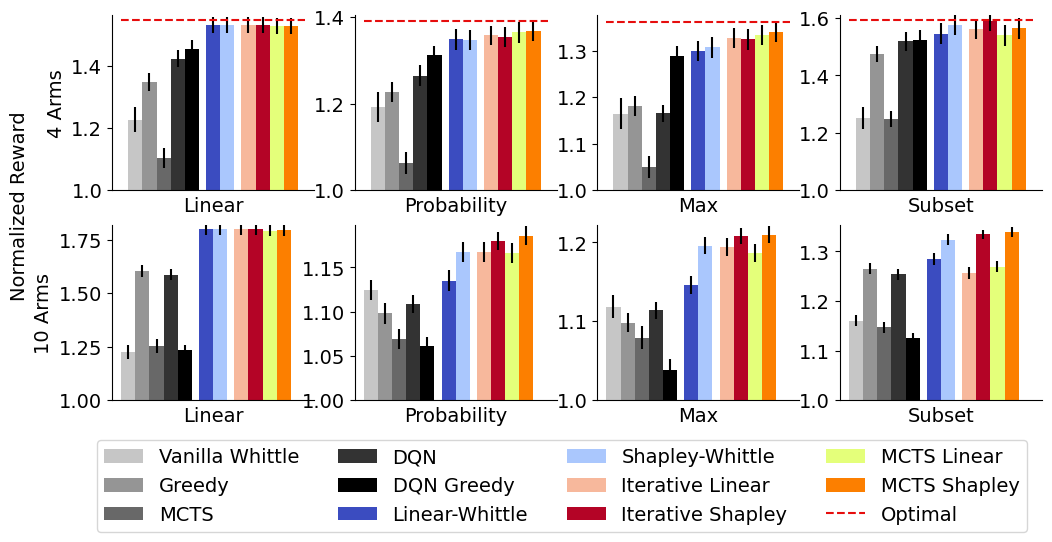

<Figure size 700x400 with 0 Axes>

In [7]:
fig, axs = plt.subplots(2,4, figsize=(12, 5))
method_names = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 105}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            if i == 0 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
                our_data = [np.array(i['{}_reward'.format(m)][0])/np.array(i['random_reward'.format(m)][0]) for i in results]
                our_data = np.mean(our_data)

                results_dqn = get_results_matching_parameters("baselines/all","",temp_params)
                dqn = [np.array(i['dqn_reward'][0])/np.array(i['random_reward'.format(m)][0]) for i in results_dqn]
                dqn = np.mean(dqn)
                dqn_2 = [np.array(i['dqn_step_reward'][0])/np.array(i['random_reward'.format(m)][0]) for i in results_dqn]
                dqn_2 = np.mean(dqn_2)



            # if i == 1 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired",m,stats.ttest_rel(best_baseline_data,our_data))

            # if i == 1 and ('shapley' in m and ('iterative' in m or 'mcts_' in m)):
            #     linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            #     linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired vs. Shapley",m,stats.ttest_rel(linear_whittle_data,our_data))


            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if num_data>0:
                # results = aggregate_data(results)
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
                    max_val = results['{}_reward'.format(m)][0]
                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    if n != 4:
                        max_val = max(max_val,results['{}_reward'.format(m)][0])

            if m not in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                best_baseline = max(best_baseline,results['{}_reward'.format(m)][0])
                if best_baseline == results['{}_reward'.format(m)][0]:
                    results = get_results_matching_parameters(dataset,"",temp_params)
                    best_baseline_data = [i['{}_reward'.format(m)][0] for i in results]
                    best_baseline_data = [i for sublist in best_baseline_data for i in sublist]



        axs[i,j].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)


        axs[i,j].set_ylim([1,max_val*1.01])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0,0].set_ylabel("4 Arms",fontsize=14)
axs[1,0].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')


1.0531313737948258
1.0513280856988543
1.0318378839513553
1.0418063794288022
1.0275988097198574
1.0400954108682066
1.0426094816770364
1.0266148803661255


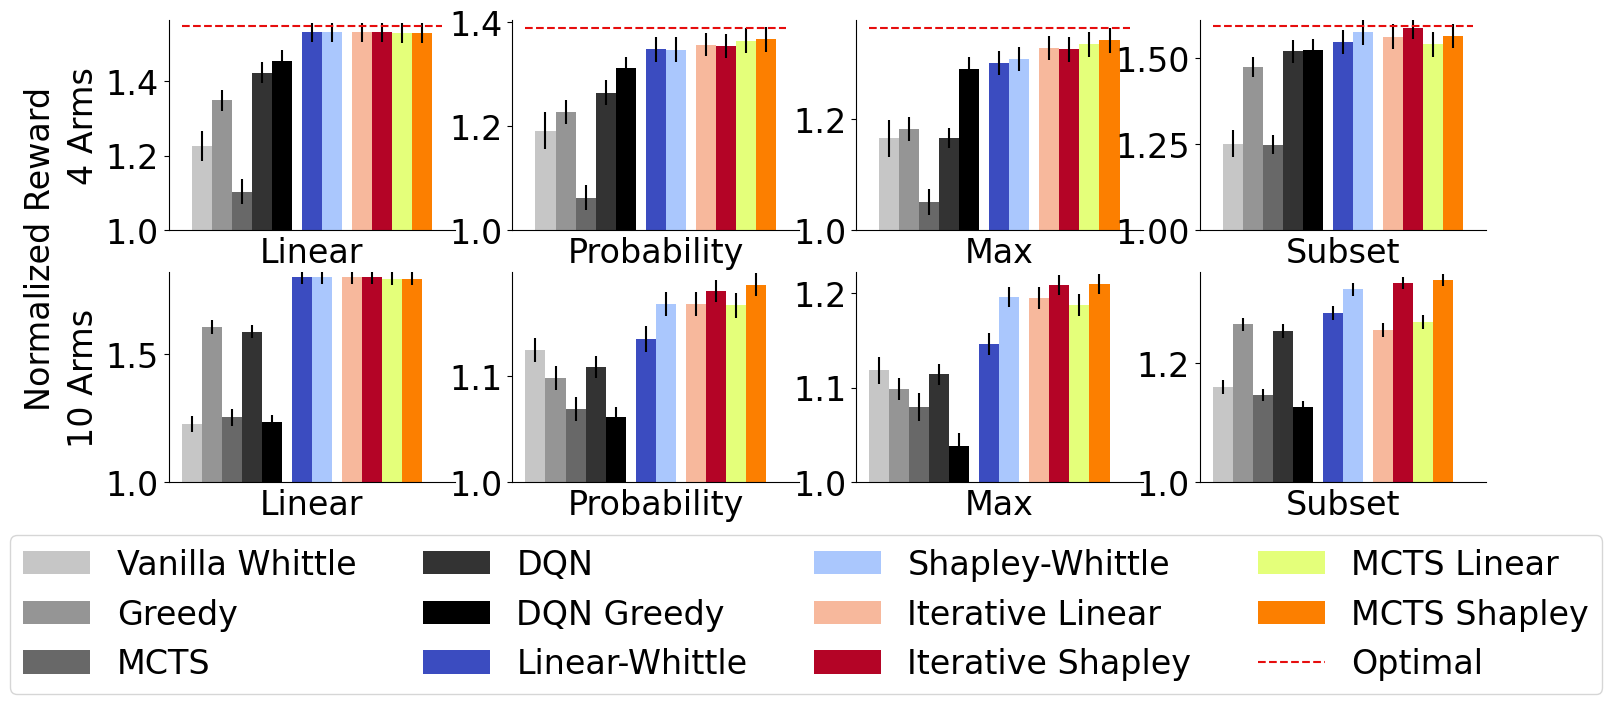

<Figure size 700x400 with 0 Axes>

In [34]:
fig, axs = plt.subplots(2,4, figsize=(17, 6))
method_names = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 105}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            if i == 0 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
                our_data = [np.array(i['{}_reward'.format(m)][0])/np.array(i['random_reward'.format(m)][0]) for i in results]
                our_data = np.mean(our_data)

                results_dqn = get_results_matching_parameters("baselines/all","",temp_params)
                dqn = [np.array(i['dqn_reward'][0])/np.array(i['random_reward'.format(m)][0]) for i in results_dqn]
                dqn = np.mean(dqn)
                dqn_2 = [np.array(i['dqn_step_reward'][0])/np.array(i['random_reward'.format(m)][0]) for i in results_dqn]
                dqn_2 = np.mean(dqn_2)


            # if i == 1 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired",m,stats.ttest_rel(best_baseline_data,our_data))

            # if i == 1 and ('shapley' in m and ('iterative' in m or 'mcts_' in m)):
            #     linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            #     linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired vs. Shapley",m,stats.ttest_rel(linear_whittle_data,our_data))


            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if num_data>0:
                # results = aggregate_data(results)
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
                    max_val = results['{}_reward'.format(m)][0]
                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    if n != 4:
                        max_val = max(max_val,results['{}_reward'.format(m)][0])

            if m not in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                best_baseline = max(best_baseline,results['{}_reward'.format(m)][0])
                if best_baseline == results['{}_reward'.format(m)][0]:
                    results = get_results_matching_parameters(dataset,"",temp_params)
                    best_baseline_data = [i['{}_reward'.format(m)][0] for i in results]
                    best_baseline_data = [i for sublist in best_baseline_data for i in sublist]



        axs[i,j].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i,j].tick_params(axis='both', which='major', labelsize=24)


        axs[i,j].set_ylim([1,max_val*1.01])
        axs[i,j].set_xlabel(reward_names[j],fontsize=24)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0,0].set_ylabel("4 Arms",fontsize=24)
axs[1,0].set_ylabel("10 Arms",fontsize=24)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=24)

fig.supylabel("Normalized Reward",fontsize=24,x=0.04)
fig.savefig("../../results/figures/all_rewards.pdf",dpi=300, bbox_inches='tight')


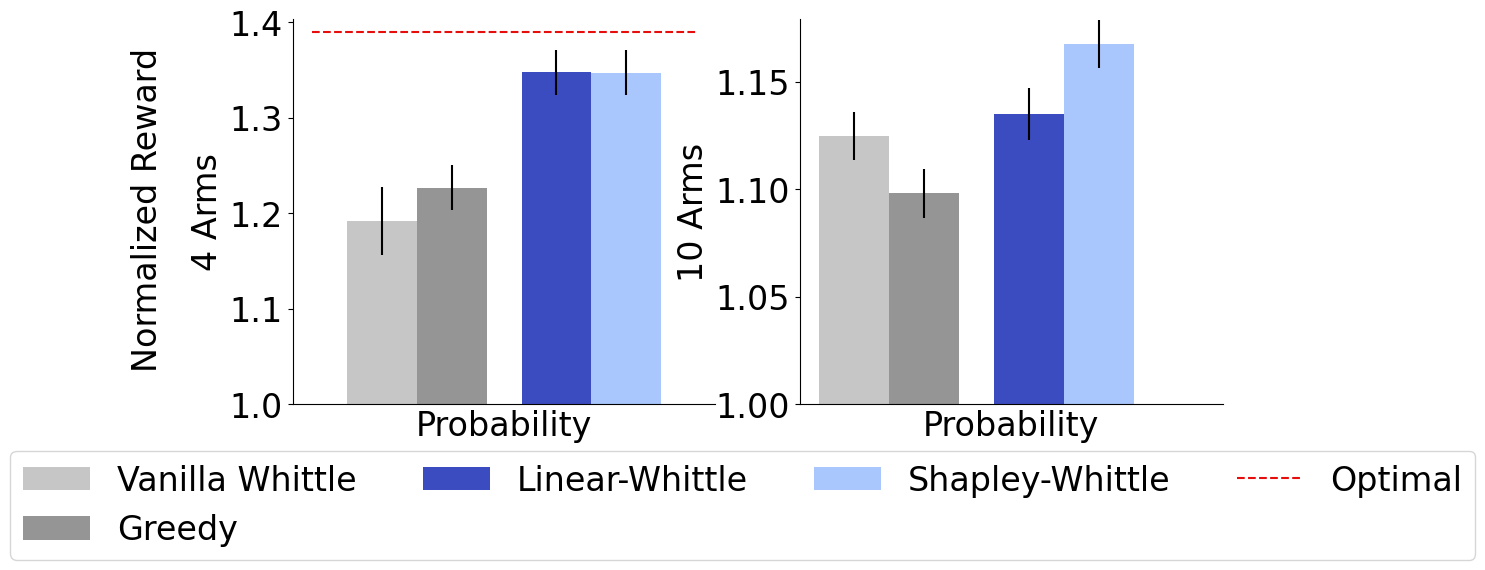

<Figure size 1000x400 with 0 Axes>

In [21]:
fig, axs = plt.subplots(1,2, figsize=(12, 5))
method_names = ['whittle_activity','greedy','linear_whittle','shapley_whittle_custom','optimal']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Shapley-Whittle","Optimal"]
width = 0.1
plt.figure(figsize=(10,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 105}
datasets = ['prob_reward']
params = [{'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1}]
reward_names = ['Probability']
x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            if i == 0 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
                our_data = [np.array(i['{}_reward'.format(m)][0])/np.array(i['random_reward'.format(m)][0]) for i in results]
                our_data = np.mean(our_data)

                results_dqn = get_results_matching_parameters("baselines/all","",temp_params)
                dqn = [np.array(i['dqn_reward'][0])/np.array(i['random_reward'.format(m)][0]) for i in results_dqn]
                dqn = np.mean(dqn)
                dqn_2 = [np.array(i['dqn_step_reward'][0])/np.array(i['random_reward'.format(m)][0]) for i in results_dqn]
                dqn_2 = np.mean(dqn_2)

                print(our_data/max(dqn,dqn_2))


            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if num_data>0:
                # results = aggregate_data(results)
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
                    max_val = results['{}_reward'.format(m)][0]
                else:
                    axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    if n != 4:
                        max_val = max(max_val,results['{}_reward'.format(m)][0])

            if m not in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                best_baseline = max(best_baseline,results['{}_reward'.format(m)][0])
                if best_baseline == results['{}_reward'.format(m)][0]:
                    results = get_results_matching_parameters(dataset,"",temp_params)
                    best_baseline_data = [i['{}_reward'.format(m)][0] for i in results]
                    best_baseline_data = [i for sublist in best_baseline_data for i in sublist]



        axs[i].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i].tick_params(axis='both', which='major', labelsize=24)


        axs[i].set_ylim([1,max_val*1.01])
        axs[i].set_xlabel(reward_names[j],fontsize=24)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0].set_ylabel("4 Arms",fontsize=24)
axs[1].set_ylabel("10 Arms",fontsize=24)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=24)

fig.supylabel("Normalized Reward",fontsize=24,x=-0.01)
fig.savefig("../../results/figures/probability_reward.pdf",dpi=300, bbox_inches='tight')


1.53662451300264
1.6451871049947109


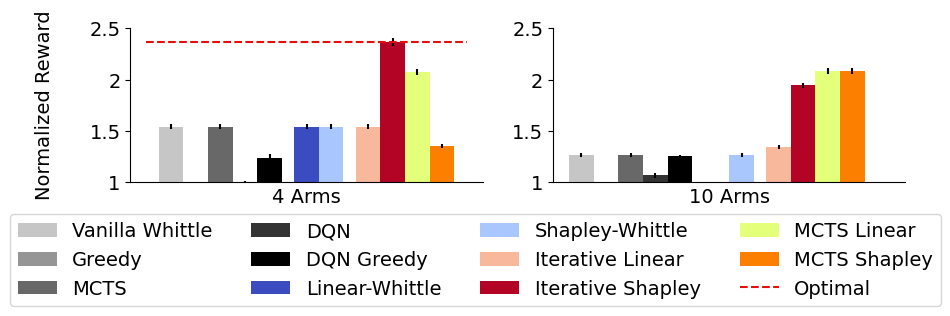

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10, 2))
method_names = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley","Optimal"]
width = 0.1
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','reward_type': 'max', 'prob_distro': 'one_time', 'n_episodes': 105}
datasets = ['max_reward']
reward_names = [""]
params = [{}, ]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    baseline_params['n_arms'] = n
    baseline_params['budget'] = n//2 
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/all"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
            dataset = "reward_variation/max_reward"

        temp_params = deepcopy(baseline_params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

            if m == 'mcts_shapley':
                print(max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0])/(max(results['shapley_whittle_custom_reward'][0],results['linear_whittle_reward'][0])))

    axs[i].set_xticks([])

    axs[i].set_yticks([1,1.5,2,2.5],[1,1.5,2,2.5],fontsize=14)
    axs[i].set_ylim([1,2.5])
    axs[i].set_xlabel("{} Arms".format(n),fontsize=14)


axs[0].set_xlabel("4 Arms",fontsize=14)
axs[1].set_xlabel("10 Arms",fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.03)
fig.savefig("../../results/figures/all_rewards_2.pdf",dpi=300, bbox_inches='tight')


### Impact of Linearity

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
Linear 1.171845953478016 1.041304783532086
MCTS 1.8255129025809405 1.224034766215555


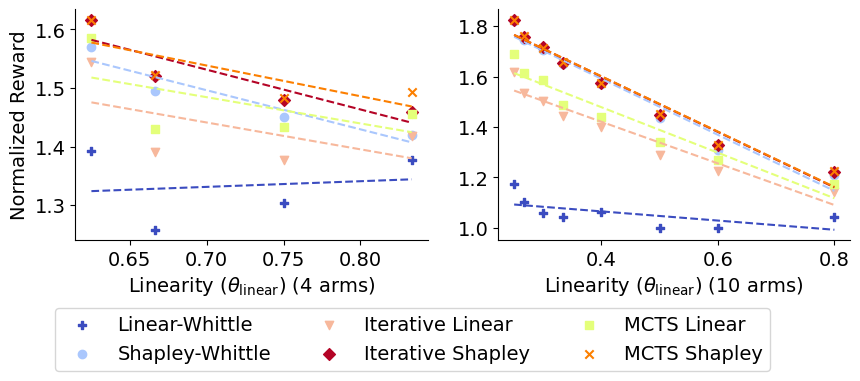

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))

method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]

arm_low_high = [(3,1),(3,2),(4,1),(4,2),(4,3),(5,1),(5,2),(5,3),(5,4)]

n_arms = [4,10]

for j,n in enumerate(n_arms):
    x_axis = []
    plots_by_method = {} 
    std_by_method = {}
    for i in method_names:
        plots_by_method[i] = []

    for arm_high,arm_low in arm_low_high:
        params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': n//2,'n_arms': n, 'arm_set_low': arm_low,'arm_set_high': arm_high,'universe_size': 20, 'prob_distro': 'linearity','reward_type': 'set_cover', 'n_episodes': 105}
        dataset = "reward_variation/subset_reward"
        results = get_results_matching_parameters(dataset,"",params)
        print(len(results))
        x_axis.append(results[0]['ratio'])

        results = aggregate_normalize_data(results,baseline="random")
        
        for method_name in method_names:
            plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])

    for i,m in enumerate(method_names):
        zipped_values = zip(x_axis,plots_by_method[m])
        zipped_values = [i for i in zipped_values if i[0] < 1.0]
        zipped_values = sorted(zipped_values,key=lambda k: k[0])
        x,y = list(zip(*zipped_values))
        axs[j].scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
        
        coefficients = np.polyfit(x, y, 1)
        slope = coefficients[0]
        intercept = coefficients[1]
        axs[j].plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])

        if m == 'mcts_shapley' and n == 10:
            print("MCTS",y[0],y[-1])
        if m == 'linear_whittle' and n == 10:
            print("Linear",y[0],y[-1])


    # plt.xlim([0.74,1.0])
    axs[j].set_xlabel("Linearity ($\\theta_{\\mathrm{linear}}$)"+" ({} arms)".format(n),fontsize=14)
    axs[j].tick_params(axis='both', which='major', labelsize=14)

    if j == 0:
        axs[j].set_ylabel("Normalized Reward",fontsize=14)
axs[0].legend(fontsize=14,bbox_to_anchor=(2,-0.25),ncol=3)

plt.savefig("../../results/figures/linearity.pdf",dpi=300, bbox_inches='tight')



15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
Linear 1.171845953478016 1.041304783532086
MCTS 1.8255129025809405 1.224034766215555


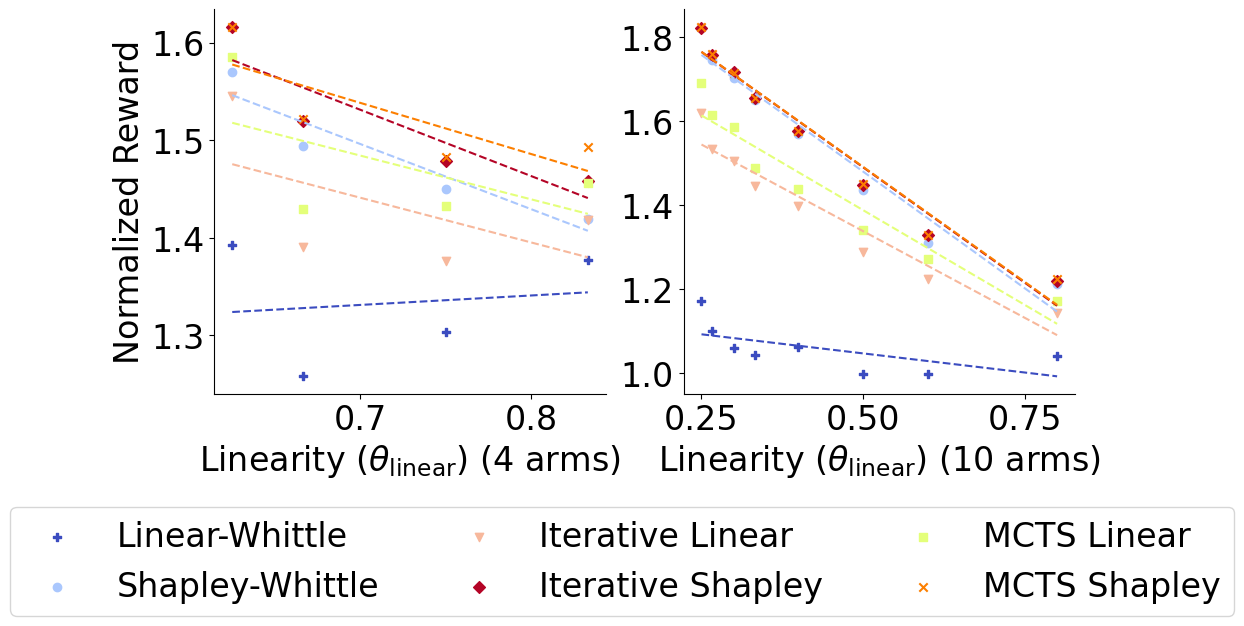

In [54]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]

arm_low_high = [(3,1),(3,2),(4,1),(4,2),(4,3),(5,1),(5,2),(5,3),(5,4)]

n_arms = [4,10]

for j,n in enumerate(n_arms):
    x_axis = []
    plots_by_method = {} 
    std_by_method = {}
    for i in method_names:
        plots_by_method[i] = []

    for arm_high,arm_low in arm_low_high:
        params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': n//2,'n_arms': n, 'arm_set_low': arm_low,'arm_set_high': arm_high,'universe_size': 20, 'prob_distro': 'linearity','reward_type': 'set_cover', 'n_episodes': 105}
        dataset = "reward_variation/subset_reward"
        results = get_results_matching_parameters(dataset,"",params)
        print(len(results))
        x_axis.append(results[0]['ratio'])

        results = aggregate_normalize_data(results,baseline="random")
        
        for method_name in method_names:
            plots_by_method[method_name].append(results['{}_reward'.format(method_name)][0])

    for i,m in enumerate(method_names):
        zipped_values = zip(x_axis,plots_by_method[m])
        zipped_values = [i for i in zipped_values if i[0] < 1.0]
        zipped_values = sorted(zipped_values,key=lambda k: k[0])
        x,y = list(zip(*zipped_values))
        axs[j].scatter(x,y,marker=shapes_by_method[m],color=colors_by_method[m],label=nice_names[i])
        
        coefficients = np.polyfit(x, y, 1)
        slope = coefficients[0]
        intercept = coefficients[1]
        axs[j].plot(x, slope * np.array(x) + intercept,'--', color=colors_by_method[m])

        if m == 'mcts_shapley' and n == 10:
            print("MCTS",y[0],y[-1])
        if m == 'linear_whittle' and n == 10:
            print("Linear",y[0],y[-1])


    # plt.xlim([0.74,1.0])
    axs[j].set_xlabel("Linearity ($\\theta_{\\mathrm{linear}}$)"+" ({} arms)".format(n),fontsize=24)
    axs[j].tick_params(axis='both', which='major', labelsize=24)
    plt.tight_layout()
    if j == 0:
        axs[j].set_ylabel("Normalized Reward",fontsize=24)
axs[0].legend(fontsize=24,bbox_to_anchor=(2.65,-0.25),ncol=3)

plt.savefig("../../results/figures/linearity.pdf",dpi=300, bbox_inches='tight')



### Time Taken

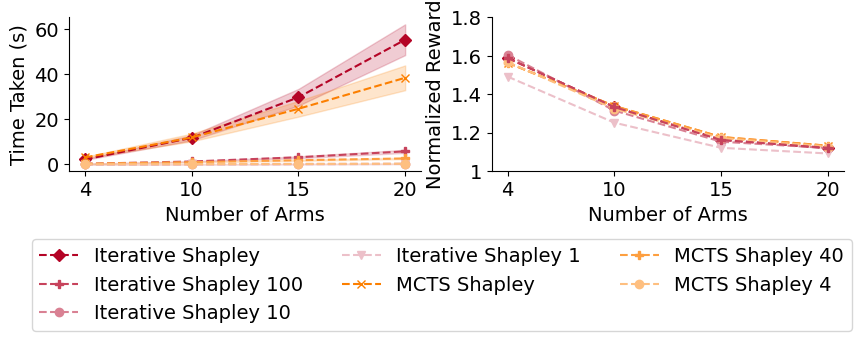

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10, 2))

method_names = ['shapley_iterative_whittle','shapley_iterative_whittle_100','shapley_iterative_whittle_10','shapley_iterative_whittle_1','mcts_shapley','mcts_shapley_40','mcts_shapley_4']
nice_names = ["Iterative Shapley","Iterative Shapley 100","Iterative Shapley 10","Iterative Shapley 1",'MCTS Shapley',"MCTS Shapley 40","MCTS Shapley 4"]
time_taken = [0.01,0.1,1]
width = 0.1
n_arms = [4,10,15,20]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,  'n_arms': n, 'arm_set_low': 6, 'arm_set_high': 8,'prob_distro': 'uniform', 'n_episodes': 105})
        results = aggregate_data(results)
        score_by_n.append(results['{}_time'.format(m)][0]/5)
        std_by_n.append(results['{}_time'.format(m)][1])
    axs[0].fill_between(list(range(len(n_arms))), np.array(score_by_n) - np.array(std_by_n), np.array(score_by_n) + np.array(std_by_n), alpha=0.2,  color=colors_by_method[m])
    axs[0].plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
axs[0].set_xticks(np.array(list(range(len(n_arms)))),n_arms)
axs[0].set_yticks([0,20,40,60],[0,20,40,60])
axs[0].set_xlabel("Number of Arms",fontsize=14)
axs[0].set_ylabel("Time Taken (s)",fontsize=14)
axs[0].legend(loc="lower right",ncol=3,bbox_to_anchor=(2.25,-1.1))

method_names = ['shapley_iterative_whittle','shapley_iterative_whittle_10','shapley_iterative_whittle_1','mcts_shapley','mcts_shapley_40','mcts_shapley_4','shapley_iterative_whittle_100']
nice_names = ["Iterative Shapley (1000 samples)","Iterative Shapley (10 samples)","Iterative Shapley (1 samples)",'MCTS Shapley (400 iterations)',"MCTS Shapley (40 iterations)","MCTS Shapley (4 iterations)","Iterative Shapley (100 samples)"]
time_taken = [0.01,0.1,1]
width = 0.1
n_arms = [4,10,15,20]

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/subset_reward"

    for n in n_arms:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5,  'n_arms': n, 'arm_set_low': 6, 'arm_set_high': 8,'prob_distro': 'uniform'})
        num_trials = len(results)
        results = aggregate_normalize_data(results,baseline='random')
        score_by_n.append(results['{}_reward'.format(m)][0])
        std_by_n.append(results['{}_reward'.format(m)][1]/num_trials**.5)
    plt.plot(list(range(len(n_arms))),score_by_n,'{}--'.format(shapes_by_method[m]),color=colors_by_method[m],label=nice_names[i])
axs[1].set_xticks(np.array(list(range(len(n_arms)))),n_arms)
axs[1].set_xlabel("Number of Arms",fontsize=14)
axs[1].set_yticks([1,1.2,1.4,1.6,1.8],[1,1.2,1.4,1.6,1.8],fontsize=14)
axs[1].set_ylim([1,1.8])
axs[1].set_ylabel("Normalized Reward",fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../../results/figures/time_reward.pdf",dpi=300, bbox_inches='tight')

### Food Rescue

0.9939892365576986
Paired shapley_whittle_custom TtestResult(statistic=nan, pvalue=nan, df=74)
Paired iterative_whittle TtestResult(statistic=0.5648589821012324, pvalue=0.5738781031309683, df=74)
Paired shapley_iterative_whittle TtestResult(statistic=-0.6570767257938106, pvalue=0.5131700610422893, df=74)
Paired mcts_linear TtestResult(statistic=-1.0167547819051317, pvalue=0.31258291331698707, df=74)
Paired mcts_shapley TtestResult(statistic=-0.9934693135595486, pvalue=0.323718797147592, df=74)
0.9950458518866263


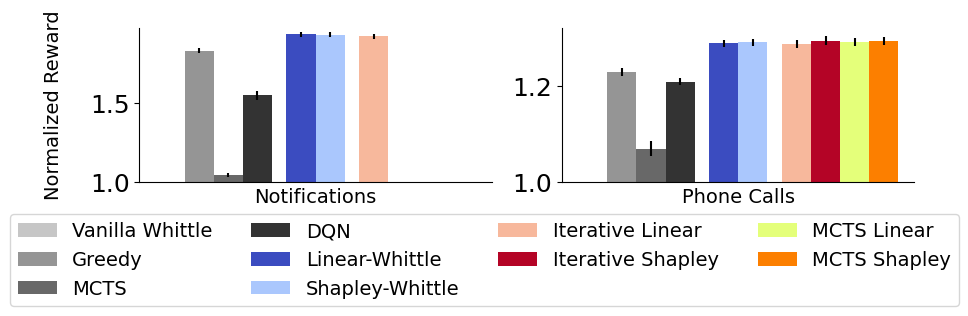

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10, 2))
method_names = ['whittle_activity','greedy','mcts','dqn_step','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5, 'time_limit': 100,'n_episodes': 105}
datasets = ['food_resuce_policies']
labels = ["Notifications","Phone Calls"]
reward_names = [""]

x_locations = [] 
shift = 0
for m in range(len(method_names)):
    if method_names[m] == 'linear_whittle':
        shift += 0.5 
    elif method_names[m] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((m+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,1,25),(20,1,10)]
for i in range(len(distros)):

    volunteers = arm_budget[i][0] 
    volunteers_per_arm = arm_budget[i][1]
    budget = arm_budget[i][2]
    params['n_arms'] = volunteers
    params['prob_distro'] = distros[i]
    
    max_val = 0
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        temp_params = deepcopy(params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if i == 1 and ('shapley' in m or 'iterative' in m or 'mcts_' in m):
            linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            our_data = [i['{}_reward'.format(m)][0] for i in results]
            our_data = [i for sublist in our_data for i in sublist]
            print("Paired",m,stats.ttest_rel(linear_whittle_data,our_data))

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
        max_val = max(max_val,results['{}_reward'.format(m)][0])
    

    axs[i].set_xticks([])

    # if i == 0:
    #     axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)
    #     axs[i].set_ylim([0,2])
    # else:
    #     axs[i].set_yticks([0,0.5,1,1.5],[0,0.5,1,1.5],fontsize=14)
    #     axs[i].set_ylim([0,1.5])

    axs[i].set_ylim([1,max_val*1.02])

    if i == 0:
        axs[i].set_xlabel("Notifications",fontsize=14)
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0]))
    else:
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0]))
        axs[i].set_xlabel("Phone Calls",fontsize=14)


handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.03)
fig.savefig("../../results/figures/food_rescue_main.pdf",dpi=300, bbox_inches='tight')


0.9939892365576986
Paired shapley_whittle_custom TtestResult(statistic=nan, pvalue=nan, df=74)
Paired iterative_whittle TtestResult(statistic=0.5648589821012324, pvalue=0.5738781031309683, df=74)
Paired shapley_iterative_whittle TtestResult(statistic=-0.6570767257938106, pvalue=0.5131700610422893, df=74)
Paired mcts_linear TtestResult(statistic=-1.0167547819051317, pvalue=0.31258291331698707, df=74)
Paired mcts_shapley TtestResult(statistic=-0.9934693135595486, pvalue=0.323718797147592, df=74)
0.9950458518866263


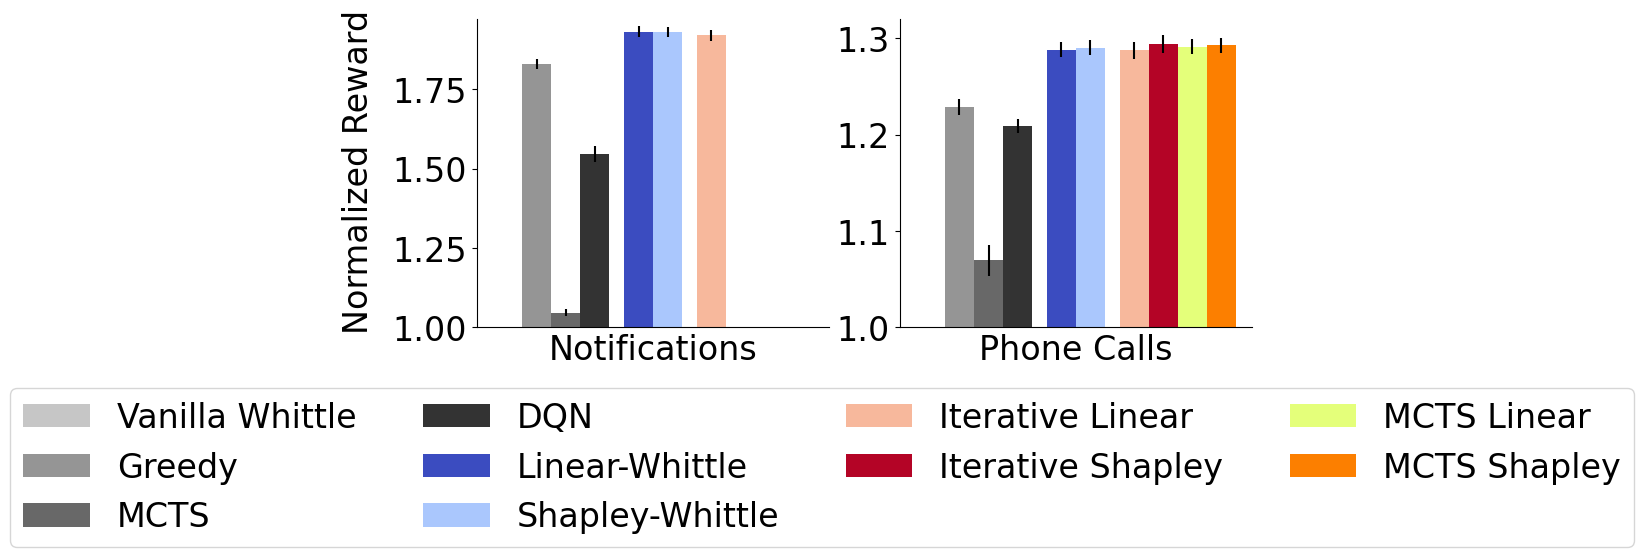

In [39]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
method_names = ['whittle_activity','greedy','mcts','dqn_step','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5, 'time_limit': 100,'n_episodes': 105}
datasets = ['food_resuce_policies']
labels = ["Notifications","Phone Calls"]
reward_names = [""]

x_locations = [] 
shift = 0
for m in range(len(method_names)):
    if method_names[m] == 'linear_whittle':
        shift += 0.5 
    elif method_names[m] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((m+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,1,25),(20,1,10)]
for i in range(len(distros)):

    volunteers = arm_budget[i][0] 
    volunteers_per_arm = arm_budget[i][1]
    budget = arm_budget[i][2]
    params['n_arms'] = volunteers
    params['prob_distro'] = distros[i]
    
    max_val = 0
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        temp_params = deepcopy(params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if i == 1 and ('shapley' in m or 'iterative' in m or 'mcts_' in m):
            linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            our_data = [i['{}_reward'.format(m)][0] for i in results]
            our_data = [i for sublist in our_data for i in sublist]
            print("Paired",m,stats.ttest_rel(linear_whittle_data,our_data))

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
        max_val = max(max_val,results['{}_reward'.format(m)][0])
    

    axs[i].set_xticks([])

    # if i == 0:
    #     axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)
    #     axs[i].set_ylim([0,2])
    # else:
    #     axs[i].set_yticks([0,0.5,1,1.5],[0,0.5,1,1.5],fontsize=14)
    #     axs[i].set_ylim([0,1.5])

    axs[i].set_ylim([1,max_val*1.02])

    if i == 0:
        axs[i].set_xlabel("Notifications",fontsize=24)
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0]))
    else:
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0]))
        axs[i].set_xlabel("Phone Calls",fontsize=24)
    
    axs[i].tick_params(axis='both', which='major', labelsize=24)


handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=24)

fig.supylabel("Normalized Reward",fontsize=24,x=-0.01)
fig.savefig("../../results/figures/food_rescue_main.pdf",dpi=300, bbox_inches='tight')


0.9939892365576986
Paired shapley_whittle_custom TtestResult(statistic=nan, pvalue=nan, df=74)
0.9950458518866263


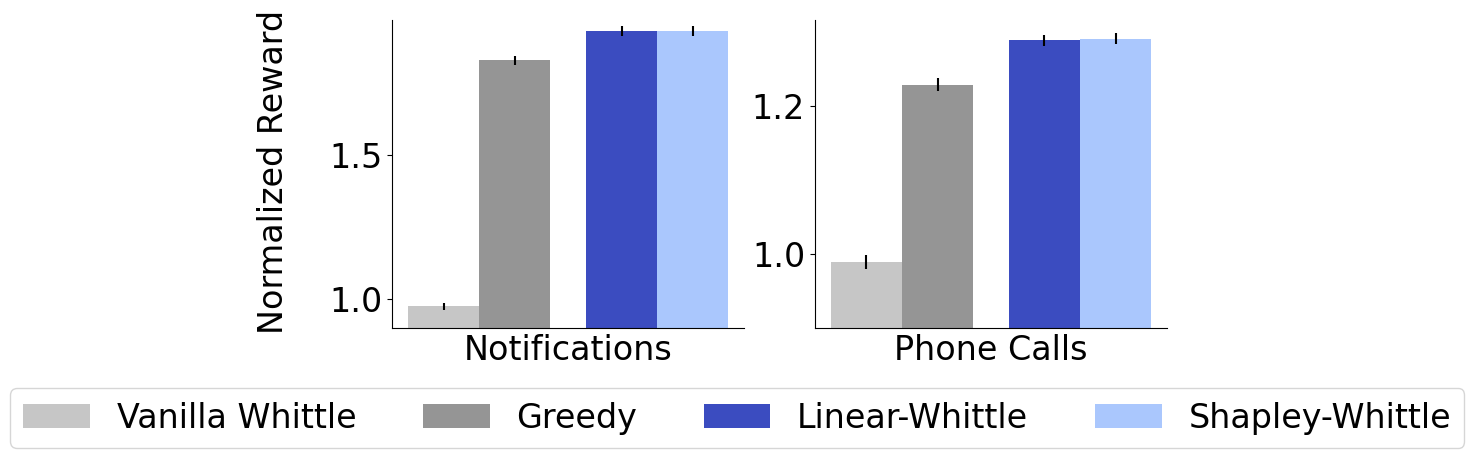

In [29]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
method_names = ['whittle_activity','greedy','linear_whittle','shapley_whittle_custom']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Shapley-Whittle"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5, 'time_limit': 100,'n_episodes': 105}
datasets = ['food_resuce_policies']
labels = ["Notifications","Phone Calls"]
reward_names = [""]

x_locations = [] 
shift = 0
for m in range(len(method_names)):
    if method_names[m] == 'linear_whittle':
        shift += 0.5 
    elif method_names[m] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((m+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,1,25),(20,1,10)]
for i in range(len(distros)):

    volunteers = arm_budget[i][0] 
    volunteers_per_arm = arm_budget[i][1]
    budget = arm_budget[i][2]
    params['n_arms'] = volunteers
    params['prob_distro'] = distros[i]
    
    max_val = 0
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        temp_params = deepcopy(params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if i == 1 and ('shapley' in m or 'iterative' in m or 'mcts_' in m):
            linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            our_data = [i['{}_reward'.format(m)][0] for i in results]
            our_data = [i for sublist in our_data for i in sublist]
            print("Paired",m,stats.ttest_rel(linear_whittle_data,our_data))

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
        max_val = max(max_val,results['{}_reward'.format(m)][0])
    

    axs[i].set_xticks([])

    # if i == 0:
    #     axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)
    #     axs[i].set_ylim([0,2])
    # else:
    #     axs[i].set_yticks([0,0.5,1,1.5],[0,0.5,1,1.5],fontsize=14)
    #     axs[i].set_ylim([0,1.5])

    axs[i].tick_params(axis='both', which='major', labelsize=24)


    axs[i].set_ylim([0.9,max_val*1.02])

    if i == 0:
        axs[i].set_xlabel("Notifications",fontsize=24)
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0]))
    else:
        print(min(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0])/max(results['linear_whittle_reward'][0],results['shapley_whittle_custom_reward'][0],results['iterative_whittle_reward'][0],results["shapley_iterative_whittle_reward"][0],results["mcts_linear_reward"][0],results["mcts_shapley_reward"][0]))
        axs[i].set_xlabel("Phone Calls",fontsize=24)


handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=24)

fig.supylabel("Normalized Reward",fontsize=24,x=-0.01)
fig.savefig("../../results/figures/food_rescue_main.pdf",dpi=300, bbox_inches='tight')


In [21]:
table_string = """\\toprule
                & Vanilla Whittle & Greedy          & MCTS            & DQN             & Linear Whittle  \\\\ \\midrule
Notifications & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} \\\\
Phone Calls   & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} \\\\ \\bottomrule \\\\  \\toprule \\\\ 
                & Shapley Whittle & Iter. Linear     & Iter. Shapley    & MCTS Linear      & MCTS Shapley \\\\ \\midrule 
Notifications & {} $\\pm$ {} & {} $\\pm$ {} &  &  &  \\\\
Phone Calls   & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} & {} $\\pm$ {} \\\\ \\bottomrule"""

values = []
method_names = ['whittle_activity','greedy','mcts','dqn_step','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","MCTS","DQN","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5,'n_episodes': 105}
datasets = ['food_resuce_policies']
labels = ["Notifications","Phone Calls"]
reward_names = [""]

x_locations = [] 
shift = 0
for m in range(len(method_names)):
    if method_names[m] == 'linear_whittle':
        shift += 0.5 
    elif method_names[m] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((m+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,1,25),(20,1,10)]

for policy_num in [0,5]:
    for i in range(len(distros)):

        volunteers = arm_budget[i][0] 
        volunteers_per_arm = arm_budget[i][1]
        budget = arm_budget[i][2]
        params['n_arms'] = volunteers
        params['prob_distro'] = distros[i]
        
        max_val = 0
        for k,m in enumerate(method_names[policy_num:policy_num+5]):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/food_rescue_policies"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
                dataset = "food_rescue_policies"

            temp_params = deepcopy(params)
            results = get_results_matching_parameters(dataset,"",temp_params)
            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])
            if i == 1 and ('shapley' in m or 'iterative' in m or 'mcts_' in m):
                linear_whittle_data = [i['linear_whittle_reward'][0] for i in results]
                linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
                our_data = [i['{}_reward'.format(m)][0] for i in results]
                our_data = [i for sublist in our_data for i in sublist]
                print("Paired",m,stats.ttest_rel(linear_whittle_data,our_data))

            if num_data>0:
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                    continue 
                score_by_n.append("{:.3f}".format(results['{}_reward'.format(m)][0]))
                std_by_n.append("{:.3f}".format(results['{}_reward'.format(m)][1]/num_data**.5))
            values.append(score_by_n[-1])
            values.append(std_by_n[-1])

print(table_string.format(*values))

Paired shapley_whittle_custom TtestResult(statistic=-2.539755827325598, pvalue=0.013191732714062128, df=74)
Paired iterative_whittle TtestResult(statistic=0.09660198872839783, pvalue=0.9233036276017498, df=74)
Paired shapley_iterative_whittle TtestResult(statistic=-1.071418845356544, pvalue=0.28746310573358413, df=74)
Paired mcts_linear TtestResult(statistic=-2.659817513296769, pvalue=0.009579746600178593, df=74)
Paired mcts_shapley TtestResult(statistic=-1.6667779133458889, pvalue=0.0997859932243735, df=74)
\toprule
                & Vanilla Whittle & Greedy          & MCTS            & DQN             & Linear Whittle  \\ \midrule
Notifications & 0.975 $\pm$ 0.012 & 1.829 $\pm$ 0.016 & 1.047 $\pm$ 0.012 & 1.547 $\pm$ 0.025 & 1.932 $\pm$ 0.017 \\
Phone Calls   & 0.989 $\pm$ 0.009 & 1.228 $\pm$ 0.008 & 1.070 $\pm$ 0.016 & 1.209 $\pm$ 0.007 & 1.288 $\pm$ 0.008 \\ \bottomrule \\  \toprule \\ 
                & Shapley Whittle & Iter. Linear     & Iter. Shapley    & MCTS Linear      & MCT

In [33]:
results = get_results_matching_parameters(dataset,"",temp_params)
linear_whittle_data = [i['linear_whittle_reward'][0] for i in results]
linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
our_data = [i['mcts_linear_reward'][0] for i in results]
our_data = [i for sublist in our_data for i in sublist]
(np.array(our_data)-np.array(linear_whittle_data))

array([ 1.10420366e-02,  2.00635629e-01,  1.43282786e-02, -1.84420893e-02,
        1.32698505e-02,  1.14575530e-01,  7.27556457e-02,  7.24439852e-03,
        1.16941768e-01,  1.41618277e-01,  4.55598985e-02, -3.71553468e-02,
        4.51011417e-02, -3.18645698e-02, -6.23611135e-04,  3.15248734e-03,
        0.00000000e+00,  1.78449352e-03, -1.94349734e-04, -8.11717071e-03,
       -5.04733105e-02,  9.99068578e-02,  6.11054389e-02,  6.93828261e-02,
        4.96713353e-02, -2.65073943e-03, -2.44074316e-02,  6.79241978e-02,
        3.92000057e-03,  2.59206667e-02, -1.56176719e-03,  3.11210901e-03,
       -7.01822096e-03, -4.49710388e-02, -4.35072487e-02, -7.98016291e-03,
       -5.70668483e-03,  7.20711934e-02,  2.90033340e-02,  6.93742734e-03,
        6.10805458e-02, -3.59864848e-02,  5.79483569e-02, -4.37692978e-02,
       -2.33149264e-02, -6.92431045e-02, -8.79796566e-03,  1.49061203e-02,
       -7.44268102e-02,  4.67111260e-02,  4.54996064e-02, -1.94260373e-02,
        9.66590962e-03, -

# Journal Plots

### Food Rescue Exploration

In [7]:
all_notifications_by_week = json.load(open('../../results/food_rescue/notifications_by_week.json'))
all_notifications_by_rescue = json.load(open('../../results/food_rescue/notifications_by_rescue.json'))

In [8]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


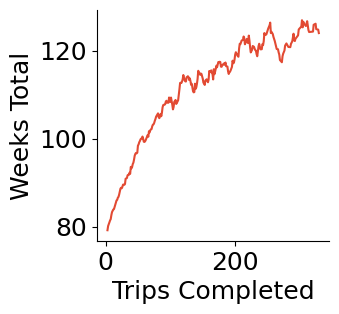

In [9]:
plt.figure(figsize=(3,3))
experience_levels = sorted([int(i) for i in list(all_notifications_by_week.keys())])
weeks_by_experience = [[len(i) for i in all_notifications_by_week[str(num_trips)] if i != 0] for num_trips in experience_levels]

plt.plot(experience_levels[:-99],moving_average([np.mean(i) for i in weeks_by_experience],n=100))
plt.xlabel("Trips Completed")
plt.ylabel("Weeks Total")
plt.savefig("../../results/figures/trips_notifications.pdf",dpi=300, bbox_inches='tight')

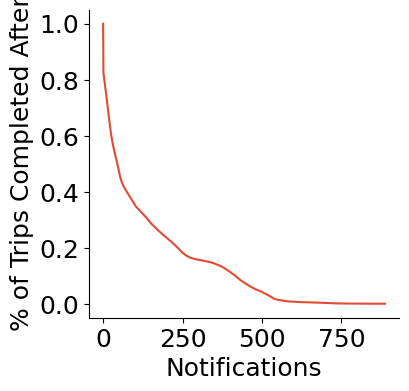

In [10]:
plt.figure(figsize=(4,4))
all_notifications = []
for num_trips in all_notifications_by_rescue:
    all_notifications += all_notifications_by_rescue[num_trips]
count_freq = Counter(all_notifications)

unique_counts = sorted(count_freq.keys())

total_counts = len(all_notifications)
cdf_values = []
for k in unique_counts:
    fraction = sum(freq for count, freq in count_freq.items() if count >= k) / total_counts
    cdf_values.append(fraction)
plt.plot(unique_counts,cdf_values)
plt.xlabel("Notifications")
plt.ylabel("% of Trips Completed After")
plt.savefig("../../results/figures/notifications_trips_after.pdf",dpi=300, bbox_inches='tight')

In [11]:
def get_interval_num(intervals,num):
    i = 0
    while i<len(intervals):
        if num<intervals[i]:
            return i 
        i+=1
    return len(intervals)

def compute_recovery_rates(notifications_by_week,intervals):
    num_trips_completed_after_by_notifications = {}
    for i in intervals:
        num_trips_completed_after_by_notifications[i] = [0,0]

    for i in notifications_by_week:
        for user in notifications_by_week:
            if user != 0:
                for idx,row in enumerate(user[:-1]):
                    num_notifications = intervals[get_interval_num(intervals,row['num_notifications'])]
                    num_trips_completed_after_by_notifications[num_notifications][int(user[idx+1]['trip_completed'])] += 1
                if len(user)>0:        
                    num_notifications = intervals[get_interval_num(intervals,user[-1]['num_notifications'])]
                    num_trips_completed_after_by_notifications[num_notifications][0] += 1
    for i in num_trips_completed_after_by_notifications:
        num_trips_completed_after_by_notifications[i] = num_trips_completed_after_by_notifications[i][1]/(num_trips_completed_after_by_notifications[i][0]+num_trips_completed_after_by_notifications[i][1])

    return num_trips_completed_after_by_notifications
intervals = [10,50,100,1000]
total_weeks = sum([sum([len(i) for i in all_notifications_by_week[str(num_trips)] if i != 0]) for num_trips in experience_levels])

recovery_rates = {}
for i in intervals:
    recovery_rates[i] = 0
for num_trips in all_notifications_by_week:
    try:
        r = compute_recovery_rates(all_notifications_by_week[num_trips],intervals)
        for i in r:
            r[i] *= sum([len(i) for i in all_notifications_by_week[str(num_trips)] if i != 0])
            r[i] /= total_weeks 
            recovery_rates[i] += r[i]
    except:
        continue 

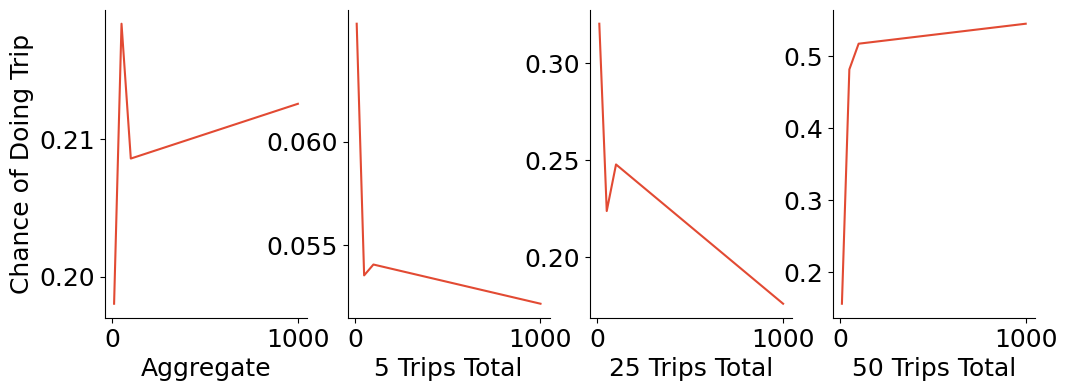

In [88]:
fig, axs = plt.subplots(1,4, figsize=(14, 4))

axs[0].plot(intervals,[recovery_rates[i] for i in intervals])
axs[0].set_ylabel("Trip Completion Rate")
axs[0].set_yticks([0.2,0.21])
axs[0].set_xlabel("Notificaitons")

r = compute_recovery_rates(all_notifications_by_week['5'],intervals)
axs[1].plot(intervals,[r[i] for i in r])
axs[1].set_xlabel("5 Trips Total")
axs[1].set_yticks([0.055,0.06])

r = compute_recovery_rates(all_notifications_by_week['25'],intervals)
axs[2].plot(intervals,[r[i] for i in r])
axs[2].set_xlabel("25 Trips Total")

r = compute_recovery_rates(all_notifications_by_week['50'],intervals)
axs[3].plot(intervals,[r[i] for i in r])
axs[3].set_xlabel("50 Trips Total")
fig.savefig("../../results/figures/recovery_rates.pdf",dpi=300, bbox_inches='tight')


### Multi-State

105
105
105


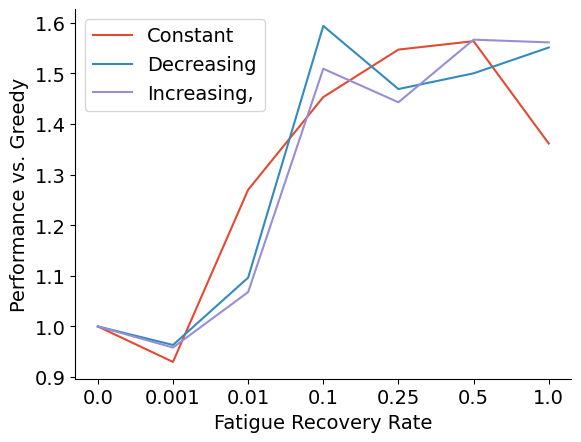

In [105]:
dataset = "journal_results/multi_state"

recovery_rates = [0.0,0.001,0.01,0.1,0.25,0.5,1.0]
nice_names = {
    'multi_state_constant': 'Constant',
    'multi_state_increasing': 'Decreasing',
    'multi_state_decreasing': 'Increasing,'
}
for prob_distro in ['multi_state_constant','multi_state_increasing','multi_state_decreasing']:
    temp_params = {'prob_distro': prob_distro}
    results = get_results_matching_parameters(dataset,"",temp_params)
    print(len(results))

    ratios = []
    for r in recovery_rates:
        corresponding_values = [i for i in results if i['parameters']['recovery_rate'] == r]
        normalized_results = aggregate_normalize_data(corresponding_values,baseline="random")
        ratios.append(normalized_results['linear_whittle_reward'][0]/normalized_results['greedy_reward'][0])
    plt.plot(list(range(len(recovery_rates))),ratios,label=nice_names[prob_distro])
plt.xticks(list(range(len(recovery_rates))),recovery_rates)
plt.xlabel("Fatigue Recovery Rate")
plt.ylabel("Performance vs. Greedy")
plt.legend()

### Two Timescale

In [108]:
dataset = "journal_results/two_timestep"
temp_params = {'n_arms': 4, 'prob_distro': 'two_timescale'}           
results = get_results_matching_parameters(dataset,"",temp_params)
num_4 = len(results)*len(results[0]['greedy_reward'])
results_4 = aggregate_normalize_data(results,baseline="random")

temp_params = {'n_arms': 10, 'prob_distro': 'two_timescale'}           
results = get_results_matching_parameters(dataset,"",temp_params)
num_10 = len(results)*len(results[0]['greedy_reward'])
results_10 = aggregate_normalize_data(results,baseline="random")

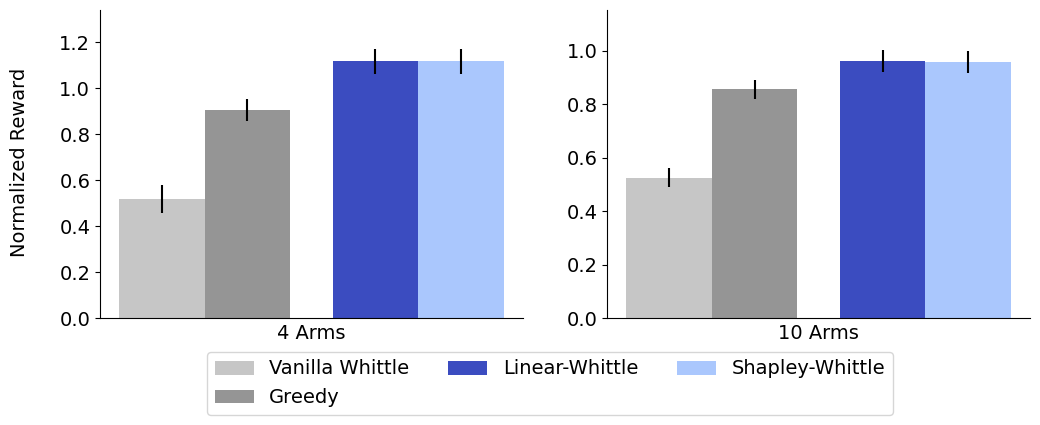

<Figure size 700x400 with 0 Axes>

In [109]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
method_names = ['whittle_activity','greedy','linear_whittle','shapley_whittle_custom']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Shapley-Whittle"]

method_names_contextual = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','contextual_whittle','shapley_whittle_custom','contextual_shapley']
nice_names_contextual = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Linear Contextual","Shapley-Whittle","Shapley Contextual"]

width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'n_episodes': 105}
datasets = ['multi_state']
reward_names = [""]
params = [ {'reward_type': 'probability_multi_state'}]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

x_locations_contextual = [] 
shift = 0
for i in range(len(method_names_contextual)):
    if method_names_contextual[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names_contextual[i] == 'iterative_whittle':
        shift += 0.5

    x_locations_contextual.append((i+shift)*width)


for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        to_loop = method_names
        if datasets[j] == 'contextual':
            to_loop = method_names_contextual


        for k,m in enumerate(to_loop):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/two_timestep"

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]

            if i == 0:
                results = results_4
                num_data = num_4
            else:
                results = results_10 
                num_data = num_10 

            if num_data>0:
                # results = aggregate_data(results)
                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if datasets[j] == 'contextual':
                    axs[i].bar(x_locations_contextual[k],score_by_n,width=width,label=nice_names_contextual[k],color=colors_by_method[m],yerr=std_by_n)
                else:
                    axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_reward'.format(m)][0])


        axs[i].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i].tick_params(axis='both', which='major', labelsize=14)


        axs[i].set_ylim([0,max_val*1.2])

        axs[i].set_xlabel(reward_names[j],fontsize=14)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0].set_xlabel("4 Arms",fontsize=14)
axs[1].set_xlabel("10 Arms",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.05)
fig.savefig("../../results/figures/multi_state.pdf",dpi=300, bbox_inches='tight')


In [65]:
dataset = "journal_results/two_timestep"
temp_params = {'n_arms': 10}           
results = get_results_matching_parameters(dataset,"",temp_params)

In [66]:
def non_overlapping_window_average(arr, K):
    # Reshape the array to have shape (-1, K) and take the mean along axis 1
    return np.mean(arr[:len(arr)//K * K].reshape(-1, K), axis=1)
K = 1250


In [96]:
value_by_method = {}
for method in ['greedy','linear_whittle']:
    avg_by_week = []
    for i in range(len(results)):
        all_data = np.array(results[i]['{}_burned_out_rate'.format(method)][0])

        num_burned_out = np.sum(all_data[:,:,:4],axis=2)/10
        week_indices = np.sum(all_data[:, :, 8:], axis=2) != 0
        indices = [np.where(i)[0] for i in week_indices]
        for idx,trial in enumerate(indices):
            averages = []
            for w in range(len(trial)-1):
                averages.append(np.mean(num_burned_out[idx,trial[w]+1:trial[w+1]]))
            avg_by_week.append(averages)
    max_length = max(len(sublist) for sublist in avg_by_week)

    # Compute the averages for each index across lists
    y_axis_values = []
    for i in range(max_length):
        valid_values = [sublist[i] for sublist in avg_by_week if i < len(sublist)]  # Gather valid values for the index
        if valid_values:
            y_axis_values.append(np.mean(valid_values))  # Compute average only for valid values
        else:
            y_axis_values.append(None)  # In case no valid values exist for the index
    value_by_method[method] = y_axis_values

Text(0.5, 0, 'Week #')

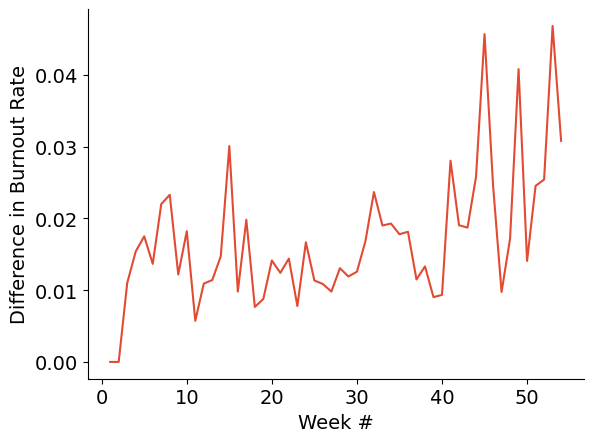

In [102]:
y_values = (np.array(value_by_method['greedy'])-np.array(value_by_method['linear_whittle']))[:-3]
plt.plot(list(range(1,len(y_values)+1)),y_values)
plt.ylabel("Difference in Burnout Rate")
plt.xlabel("Week #")

### Contextual

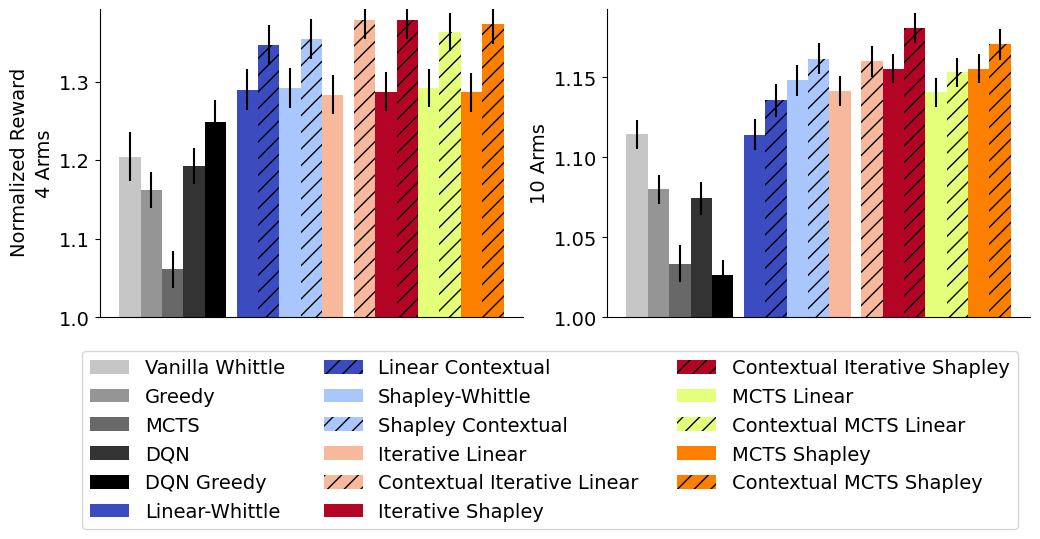

<Figure size 700x400 with 0 Axes>

In [62]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
method_names_contextual = ['whittle_activity','greedy','mcts','dqn_step','dqn','linear_whittle','contextual_whittle','shapley_whittle_custom','contextual_shapley','non_contextual_iterative_whittle','iterative_whittle','non_contextual_shapley_iterative_whittle','shapley_iterative_whittle','non_contextual_mcts_linear','mcts_linear','non_contextual_mcts_shapley','mcts_shapley']
nice_names_contextual = ["Vanilla Whittle","Greedy","MCTS","DQN","DQN Greedy","Linear-Whittle","Linear Contextual","Shapley-Whittle","Shapley Contextual","Iterative Linear","Contextual Iterative Linear","Iterative Shapley","Contextual Iterative Shapley","MCTS Linear","Contextual MCTS Linear","MCTS Shapley","Contextual MCTS Shapley"]

width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'n_episodes': 105}
datasets = ['contextual']
reward_names = [""]
params = [{'reward_type': 'probability_context', 'prob_distro': 'uniform_context'}]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'non_contextual_iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

x_locations_contextual = [] 
shift = 0
for i in range(len(method_names_contextual)):
    if method_names_contextual[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names_contextual[i] == 'iterative_whittle':
        shift += 0.5

    x_locations_contextual.append((i+shift)*width)


for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        to_loop = method_names
        if datasets[j] == 'contextual':
            to_loop = method_names_contextual


        for k,m in enumerate(to_loop):
            score_by_n = []
            std_by_n = []

            if m in ['greedy','mcts','dqn_step','dqn']:
                dataset = "baselines/journal"
            else:
                dataset = "journal_results/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]


            results = get_results_matching_parameters(dataset,"",temp_params)
            # if i == 1 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired",m,stats.ttest_rel(best_baseline_data,our_data))

            # if i == 1 and ('shapley' in m and ('iterative' in m or 'mcts_' in m)):
            #     linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            #     linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired vs. Shapley",m,stats.ttest_rel(linear_whittle_data,our_data))

            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])
            if num_data>0:
                # results = aggregate_data(results)
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if datasets[j] == 'contextual':
                    if 'non_context' in m or m == 'mcts':
                        axs[i].bar(x_locations_contextual[k],score_by_n,width=width,label=nice_names_contextual[k],color=colors_by_method[m],yerr=std_by_n)
                    elif 'context' in m or 'iterative' in m or 'mcts' in m:
                        axs[i].bar(x_locations_contextual[k],score_by_n,width=width,label=nice_names_contextual[k],color=colors_by_method[m],yerr=std_by_n,hatch='//')
                    else:
                        axs[i].bar(x_locations_contextual[k],score_by_n,width=width,label=nice_names_contextual[k],color=colors_by_method[m],yerr=std_by_n)
                else:
                    axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_reward'.format(m)][0])


        axs[i].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i].tick_params(axis='both', which='major', labelsize=14)


        axs[i].set_ylim([1,max_val*1.01])

        axs[i].set_xlabel(reward_names[j],fontsize=14)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0].set_ylabel("4 Arms",fontsize=14)
axs[1].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.05)
fig.savefig("../../results/figures/contextual.pdf",dpi=300, bbox_inches='tight')


In [49]:
dataset = "journal_results/contextual"
temp_params = {'n_arms': 4, 'prob_distro': 'two_timescale_context'}           
results = get_results_matching_parameters(dataset,"",temp_params)
num_data_4 = len(results)
results_4 = aggregate_normalize_data(results,baseline="random")

temp_params = {'n_arms': 10,'prob_distro': 'two_timescale_context'}           
results = get_results_matching_parameters(dataset,"",temp_params)
num_data_10 = len(results)
results_10 = aggregate_normalize_data(results,baseline="random")

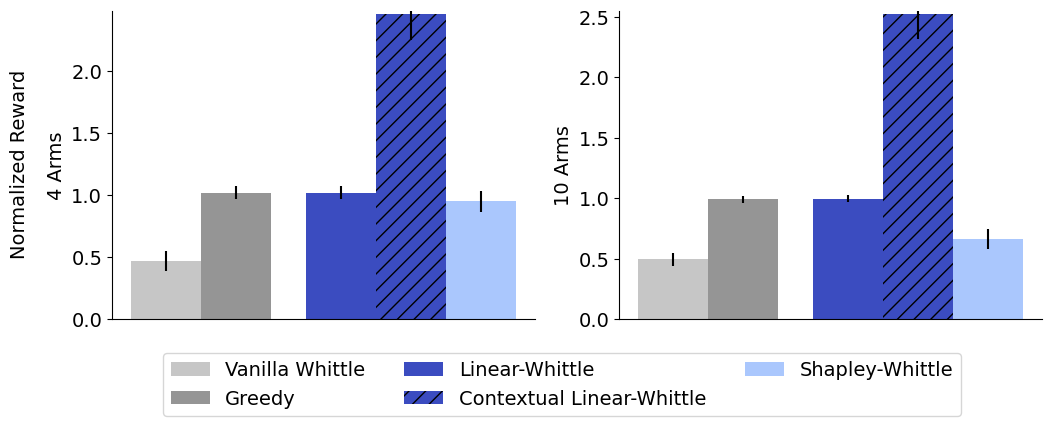

<Figure size 700x400 with 0 Axes>

In [61]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
method_names = ['whittle_activity','greedy','linear_whittle','fast_contextual_whittle','shapley_whittle_custom']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Contextual Linear-Whittle","Shapley-Whittle"]

width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'n_episodes': 105}
datasets = ['contextual']
reward_names = [""]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

x_locations_contextual = [] 
shift = 0
for i in range(len(method_names_contextual)):
    if method_names_contextual[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names_contextual[i] == 'iterative_whittle':
        shift += 0.5

    x_locations_contextual.append((i+shift)*width)


for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        to_loop = method_names


        for k,m in enumerate(to_loop):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/contextual"

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]

            if i == 0:
                results = results_4 
                num_data = num_data_4
            else:
                results = results_10 
                num_data = num_data_10

            if num_data>0:
                # results = aggregate_data(results)
                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                hatch = ''
                if 'context' in m:
                    hatch = '//'
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n,hatch=hatch)
                max_val = max(max_val,results['{}_reward'.format(m)][0])


        axs[i].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i].tick_params(axis='both', which='major', labelsize=14)


        axs[i].set_ylim([0,max_val*1.01])

        axs[i].set_xlabel(reward_names[j],fontsize=14)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0].set_ylabel("4 Arms",fontsize=14)
axs[1].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)
fig.savefig("../../results/figures/multi_state.pdf",dpi=300, bbox_inches='tight')


### Ablations

#### Non Submodular Rewards

whittle_activity (0.5230703442393063, 0.4367396178497347)
greedy (1.0, 0.0)
linear_whittle (1.125347033569909, 0.13849400645826973)
shapley_whittle_custom (1.125347033569909, 0.13849400645826973)
iterative_whittle (1.125347033569909, 0.13849400645826973)
shapley_iterative_whittle (1.125347033569909, 0.13849400645826973)
mcts_linear (1.1381156930418228, 0.15676316378724903)
mcts_shapley (1.1388755976301475, 0.1565656444530839)
optimal (1.1472328358708603, 0.1526946973875796)


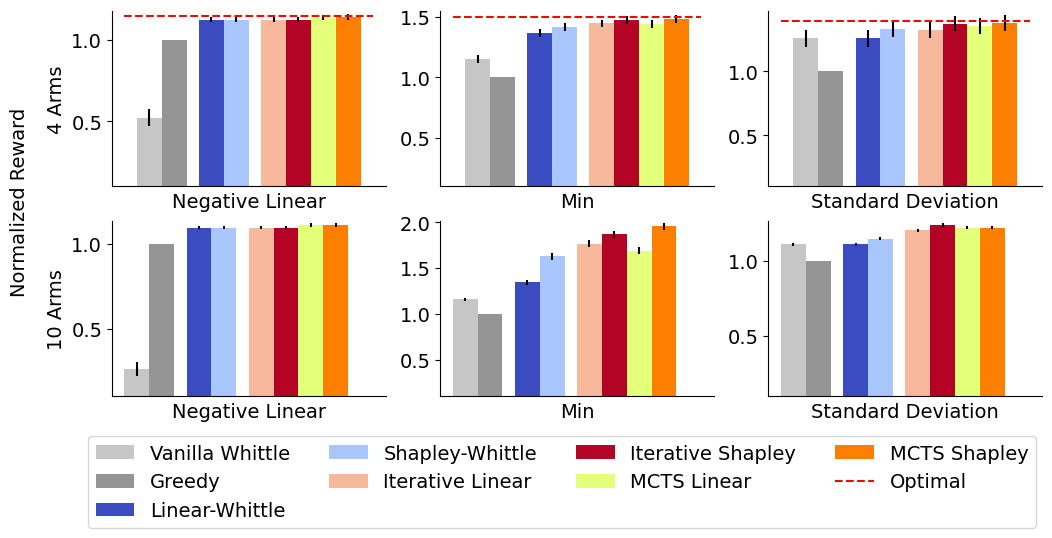

<Figure size 700x400 with 0 Axes>

In [18]:
fig, axs = plt.subplots(2,3, figsize=(12, 5))
method_names = ['whittle_activity','greedy','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley","Optimal"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [4,10]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform','n_episodes': 105}
datasets = ['non_monotonic','non_monotonic']
reward_names = ["Negative Linear","Min","Standard Deviation"]
params = [{'reward_type': 'linear','arm_set_low': -1, 'arm_set_high': 1},
            {'reward_type': 'min','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'std', 'arm_set_low': 0, 'arm_set_high': 1}]
x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 

        best_baseline = 0
        best_baseline_data = []
        max_val = 0

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "reward_variation/non_monotonic"

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)

            # if i == 1 and (m == 'mcts_shapley' or m == 'shapley_iterative_whittle'):
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired",m,stats.ttest_rel(best_baseline_data,our_data))

            # if i == 1 and ('shapley' in m and ('iterative' in m or 'mcts_' in m)):
            #     linear_whittle_data = [i['shapley_whittle_custom_reward'][0] for i in results]
            #     linear_whittle_data = [i for sublist in linear_whittle_data for i in sublist]
            #     our_data = [i['{}_reward'.format(m)][0] for i in results]
            #     our_data = [i for sublist in our_data for i in sublist]
            #     print("Paired vs. Shapley",m,stats.ttest_rel(linear_whittle_data,our_data))


            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            

            if num_data>0:
                # results = aggregate_data(results)
                results = aggregate_normalize_data(results,baseline="greedy")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]


                if i == 0 and j == 0:
                    print(m,results['{}_reward'.format(m)])
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
                    max_val = max(max_val,results['{}_reward'.format(m)][0]+results['{}_reward'.format(m)][1]/num_data**.5)
                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    # if n != 4:
                    max_val = max(max_val,results['{}_reward'.format(m)][0]+results['{}_reward'.format(m)][1]/num_data**.5)



        axs[i,j].set_xticks([])

        # if max_val < 0.2:
        #     axs[i,j].set_yticks([0,0.1],[0,0.1],fontsize=14)
        # else:
        #     axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8],[0,0.2,0.4,0.6,0.8],fontsize=14)
        axs[i,j].tick_params(axis='both', which='major', labelsize=14)


        axs[i,j].set_ylim([0.1,max_val*1.01])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)

        # if i == 0:
        #     print(best_baseline/max(results['mcts_shapley_reward'][0],results['shapley_iterative_whittle_reward'][0]))

        

axs[0,0].set_ylabel("4 Arms",fontsize=14)
axs[1,0].set_ylabel("10 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
handles[-1] = plt.Line2D([0], [0], color=colors_by_method['optimal'], linestyle='--', label='Horizontal line')

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)
fig.savefig("../../results/figures/non_monotonic.pdf",dpi=300, bbox_inches='tight')


In [35]:
temp_params['n_arms'] = 4
temp_params['budget'] = 2
temp_params['seed'] = 45
temp_params['reward_type'] = 'linear'
temp_params['arm_set_low'] = -1

In [37]:
results = get_results_matching_parameters(dataset,"",temp_params)
np.mean(results[0]['shapley_iterative_whittle_reward']), np.mean(results[0]['mcts_linear_reward'])

(2.5418922215334385, 3.0081057794900685)

#### Food Rescue Exploration

/tmp/ipykernel_112049/1690717028.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


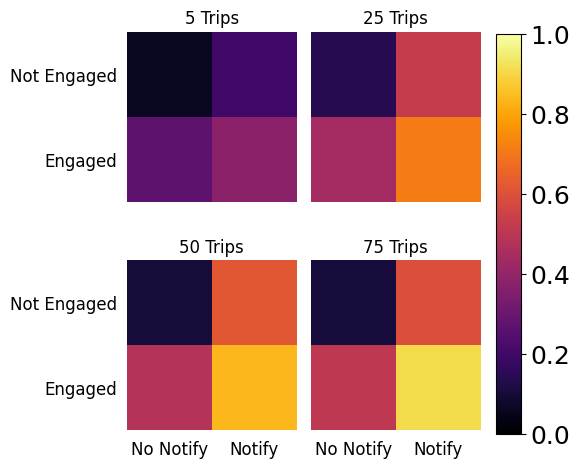

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
all_population_size = 100 
all_transitions = get_all_transitions(all_population_size)
vmax=  1
vmin = 0

transition_sizes = [[3,23],[48,73]]

for i in range(2):
    for j in range(2):
        a = axs[i,j].imshow(all_transitions[transition_sizes[i][j],:,:,1],cmap='inferno',vmax=vmax,vmin=vmin)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title("{} Trips".format(transition_sizes[i][j]+2))

        if i == 1:
            axs[i,j].set_xticks([0,1],['No Notify','Notify'],fontsize=12)
        
        if j == 0:
            axs[i,j].set_yticks([0,1],['Not Engaged','Engaged'],fontsize=12)
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['left'].set_visible(False)
        axs[i,j].spines['bottom'].set_visible(False)
        axs[i,j].tick_params(left=False,bottom=False)

# fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
fig.colorbar(a, cax=cbar_ax)

# Adjust layout
plt.tight_layout()
plt.savefig("../../results/figures/transition_distro_food_rescue.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_112049/1171396222.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ratios, color="blue", shade=True)


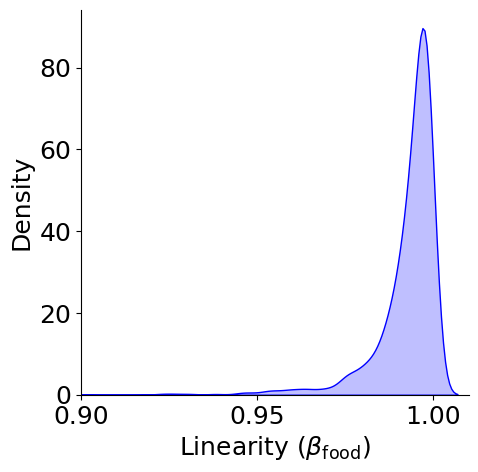

In [14]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(5,5))

samples = 1000
ratios = []

combination_probs = [math.comb(len(probs_by_user),i) for i in range(1,6)]
combination_probs = np.array(combination_probs)
combination_probs = combination_probs/np.sum(combination_probs)

for i in range(samples):
    choices = np.random.choice(list(range(len(all_non_zero_probs))),random.choices(list(range(1,6)), combination_probs)[0])
    sum_probabilities = np.sum(all_non_zero_probs[choices])
    actual_prob = 1
    for prob in all_non_zero_probs[choices]:
        actual_prob *= (1-prob)
    actual_prob = 1-actual_prob
    ratios.append(actual_prob/sum_probabilities)
sns.kdeplot(ratios, color="blue", shade=True)
plt.xticks([0.9,0.95,1.0])
plt.xlim([0.9,1.01])
plt.xlabel("Linearity ($\\beta_{\\mathrm{food}}$)")
plt.savefig("../../results/figures/food_rescue_distro.pdf",dpi=300, bbox_inches='tight')


/tmp/ipykernel_112049/11957407.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)


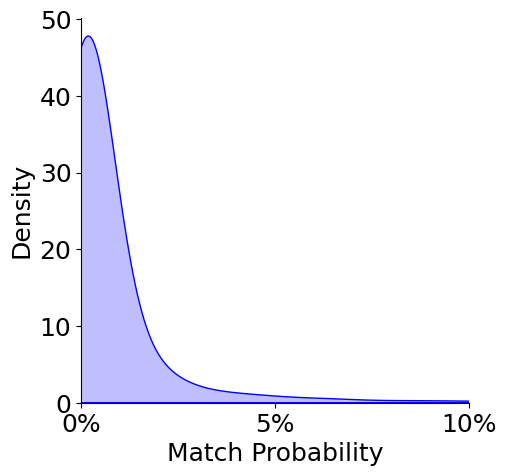

In [15]:
probs_by_user = json.load(open("../../results/food_rescue/match_probs.json","r"))
all_non_zero_probs = np.array([probs_by_user[i] for i in probs_by_user if probs_by_user[i]>0])

plt.figure(figsize=(5,5))

sns.kdeplot(all_non_zero_probs, color="blue", shade=True,gridsize=10000)
plt.xlim([0.0,0.1])
plt.xticks([0,0.05,0.1],['0%','5%','10%'])
plt.xlabel("Match Probability")
plt.savefig("../../results/figures/food_rescue_match_distro.pdf",dpi=300, bbox_inches='tight')


#### Budget/N Arms Ablation

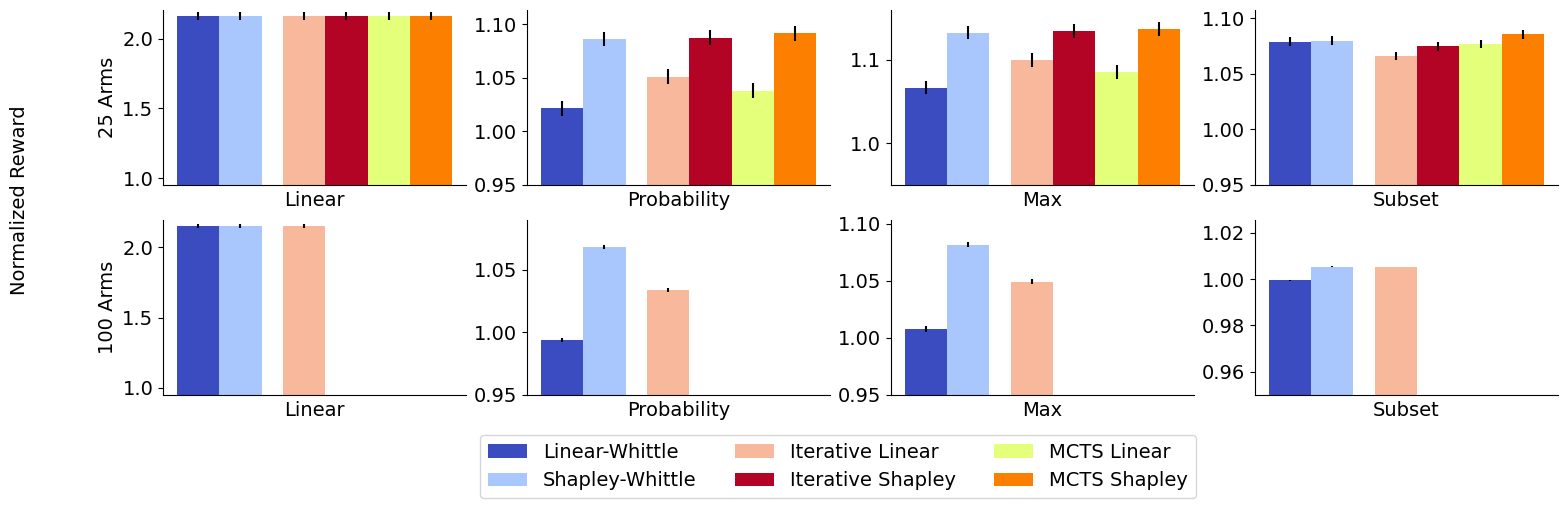

<Figure size 700x400 with 0 Axes>

In [16]:
fig, axs = plt.subplots(2,4, figsize=(18, 5))
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
width = 0.1
plt.figure(figsize=(7,4))
n_arms = [25,100]

baseline_params = {'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 2, 'n_arms': 4, 'time_limit': 100,'prob_distro': 'uniform', 'n_episodes': 105}
datasets = ['linear_reward','prob_reward','max_reward','subset_reward']
reward_names = ["Linear","Probability","Max","Subset"]
params = [{'reward_type': 'linear','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'probability','arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'max', 'arm_set_low': 0, 'arm_set_high': 1},
            {'reward_type': 'set_cover', 'universe_size': 20, 'arm_set_low': 6, 'arm_set_high': 8}]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

for i,n in enumerate(n_arms):
    for j in range(len(reward_names)):
        baseline_params['n_arms'] = n
        baseline_params['budget'] = n//2 
        max_val = 0
        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            dataset = "baselines/all"

            if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley','optimal']:
                dataset = "reward_variation/{}".format(datasets[j])

            temp_params = deepcopy(baseline_params)
            for p in params[j]:
                temp_params[p] = params[j][p]
                        
            results = get_results_matching_parameters(dataset,"",temp_params)
            num_data = 0
            if len(results)>0:
                num_data = len(results)*len(results[0]['greedy_reward'][0])

            if num_data>0:
                results = aggregate_normalize_data(results,baseline="random")

                if '{}_reward'.format(m) not in results:
                    results['{}_reward'.format(m)] = [0,0]
                score_by_n.append(results['{}_reward'.format(m)][0])
                std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
            
                if m == 'optimal' and n == 4:
                    axs[i,j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

                else:
                    axs[i,j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                    max_val = max(max_val,results['{}_reward'.format(m)][0])

        axs[i,j].set_xticks([])

        axs[i,j].set_ylim([0.95,max_val*1.02])


        # if j != 0:
        axs[i,j].tick_params(axis='y', labelsize=14)
        # else:
        #     axs[i,j].set_yticks([0,1,2],[0,1,2],fontsize=14)
        # axs[i,j].set_ylim([0,2.5])
        axs[i,j].set_xlabel(reward_names[j],fontsize=14)

axs[0,0].set_ylabel("25 Arms",fontsize=14)
axs[1,0].set_ylabel("100 Arms",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=3,bbox_to_anchor=(0.5,0.05),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.04)

fig.savefig("../../results/figures/all_rewards_large_N.pdf",dpi=300, bbox_inches='tight')


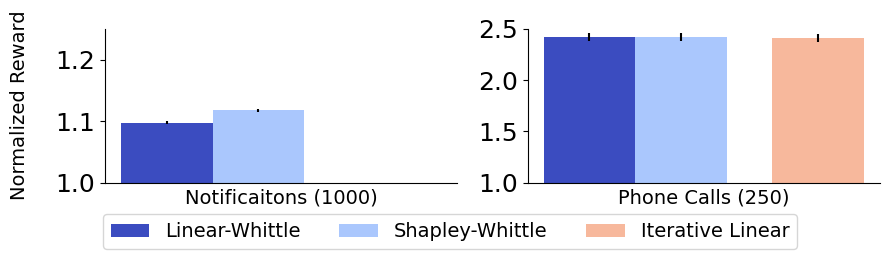

In [17]:
distros = ["food_rescue","food_rescue_top"]
fig, axs = plt.subplots(1,2, figsize=(10, 2))
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear"]
width = 0.1
n_arms = [4,10]

params = {'lamb': 0.5, 'time_limit': 100,'n_episodes': 5}
datasets = ['food_resuce_policies']
reward_names = [""]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'linear_whittle':
        shift += 0.5 
    elif method_names[i] == 'iterative_whittle':
        shift += 0.5

    x_locations.append((i+shift)*width)

distros = ["food_rescue","food_rescue_top"]
arm_budget = [(100,10,250),(5,50,5)]
for i in range(len(distros)):
    volunteers = arm_budget[i][0] 
    volunteers_per_arm = arm_budget[i][1]
    budget = arm_budget[i][2]
    params['n_arms'] = volunteers
    params['prob_distro'] = distros[i]
    
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        dataset = "baselines/food_rescue_policies"

        if m in ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_shapley','mcts_linear']:
            dataset = "food_rescue_policies"

        temp_params = deepcopy(params)
        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
        
            if m == 'optimal' and n == 4:
                axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])

            else:
                axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)

    axs[i].set_xticks([])

    # axs[i].set_yticks([0,1,2],[0,1,2],fontsize=14)

    if i == 1:
        axs[i].set_ylim([1,2.5])
    else:
        axs[i].set_ylim([1,1.25])


    if i == 0:
        axs[i].set_xlabel("Notificaitons".format(n),fontsize=14)
    else:
        axs[i].set_xlabel("Phone Calls".format(n),fontsize=14)


axs[0].set_xlabel("Notificaitons (1000)",fontsize=14)
axs[1].set_xlabel("Phone Calls (250)",fontsize=14)

handles, labels = axs[1].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.47,0),fontsize=14)

fig.supylabel("Normalized Reward",fontsize=14,x=0.03)
fig.savefig("../../results/figures/food_rescue_secondary.pdf",dpi=300, bbox_inches='tight')


#### MCTS RL Ablations

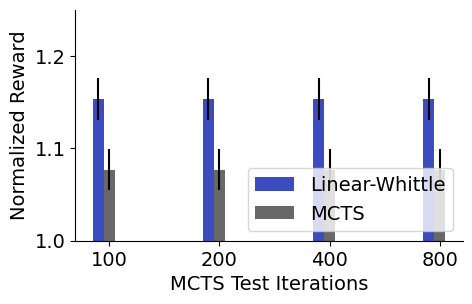

In [41]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear-Whittle","MCTS"]
mcts_iterations = [100,200,400,800]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for test_iterations in mcts_iterations:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': 2, 'mcts_test_iterations': test_iterations, 'n_episodes': 5})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])
        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.ylim([1.0,1.25])
    plt.bar(np.array(list(range(len(mcts_iterations))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="lower right",fontsize=14)
plt.xticks(np.array(list(range(len(mcts_iterations))))+width*len(method_names)/2,mcts_iterations,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("MCTS Test Iterations",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/mcts_iterations.pdf",dpi=300, bbox_inches='tight')

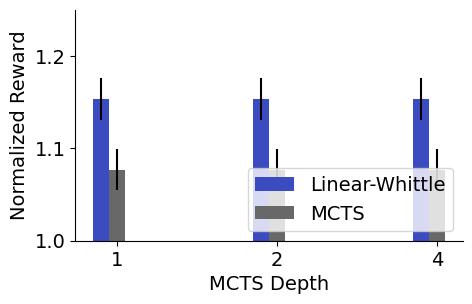

In [22]:
method_names = ['linear_whittle','mcts']
nice_names = ["Linear-Whittle","MCTS"]
mcts_depth = [1,2,4]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/mcts"

    for depth in mcts_depth:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'budget': 5, 'n_arms': 10, 'mcts_depth': depth, 'mcts_test_iterations': 400, 'n_episodes': 5})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.ylim([1.0,1.25])
    plt.bar(np.array(list(range(len(mcts_depth))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
plt.legend(loc="lower right",fontsize=14)
plt.xticks(np.array(list(range(len(mcts_depth))))+width*len(method_names)/2,mcts_depth,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("MCTS Depth",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/mcts_depth.pdf",dpi=300, bbox_inches='tight')

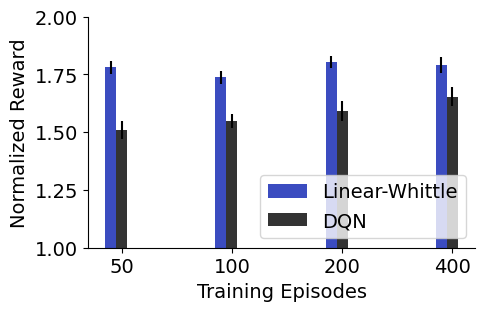

In [ ]:
method_names = ["linear_whittle",'dqn_step']
nice_names = ["Linear-Whittle","DQN"]
n_episodes = [50,100,200,400]
width = 0.1
plt.figure(figsize=(5,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/rl"

    for n_episode in n_episodes:
        results = get_results_matching_parameters(dataset,"",{'n_arms': 10,  'volunteers_per_arm': 1,  'n_episodes': n_episode+5, 'time_limit': 100, 'reward_type': 'linear'})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    if m in colors_by_method:
        plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
    else:
        plt.bar(np.array(list(range(len(n_episodes))))+i*width,score_by_n,width=width,label=nice_names[i])
    plt.ylim([1.0,2])
plt.legend(loc="lower right",fontsize=14)
plt.xticks(np.array(list(range(len(n_episodes))))+width*len(method_names)/2,n_episodes,fontsize=14)
plt.xlabel("Training Episodes",fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/dqn_ablation.pdf",dpi=300, bbox_inches='tight')

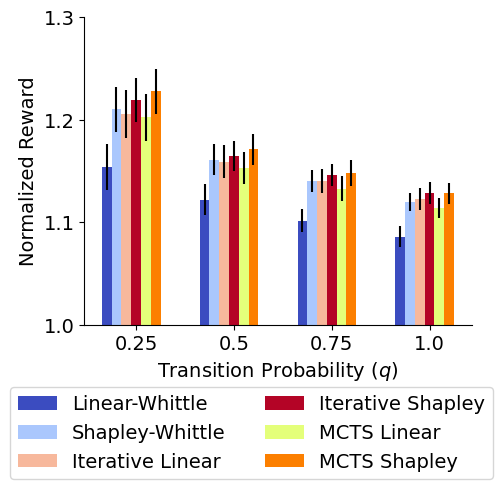

In [29]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
min_prob = [0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(5,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "baselines/synthetic_transitions"

    for prob in min_prob:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': 5, 'n_arms': 10, 'max_transition_prob': prob, 'n_episodes': 5})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(min_prob))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
    plt.ylim([1.0,1.3])
plt.legend(loc="upper right",bbox_to_anchor=(1.08,-0.17),fontsize=14,ncol=2)
plt.xticks(np.array(list(range(len(min_prob))))+width*len(method_names)/2,min_prob,fontsize=14)
plt.xlabel("Transition Probability ($q$)",fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/synthetic_transition.pdf",dpi=300, bbox_inches='tight')

#### Alpha

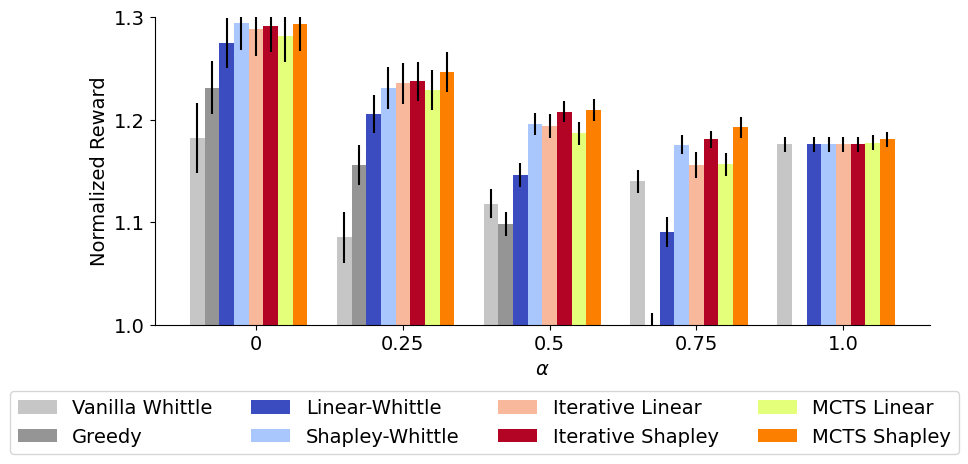

In [23]:
method_names = ['whittle_activity','greedy','linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Vanilla Whittle","Greedy","Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
lamb_values = [0,0.25,0.5,0.75,1.0]
width = 0.1
plt.figure(figsize=(10,4))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for lamb in lamb_values:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': lamb, 'budget': 5, 'n_arms': 10, 'arm_set_low': 0, 'arm_set_high': 1, 'prob_distro': 'uniform', 'n_episodes': 105})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(lamb_values))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
    plt.ylim([1.0,1.3])
plt.legend(loc="lower right",fontsize=14,ncol=4,bbox_to_anchor=(1.05,-0.45))
plt.xticks(np.array(list(range(len(lamb_values))))+width*len(method_names)/2,lamb_values,fontsize=14)
plt.xlabel("$\\alpha$",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("../../results/figures/alpha.pdf",dpi=300, bbox_inches='tight')

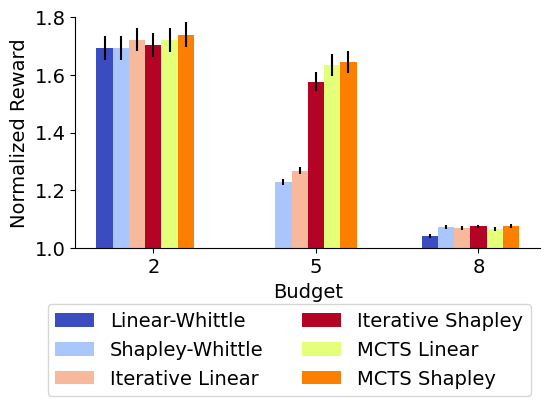

In [24]:
method_names = ['linear_whittle','shapley_whittle_custom','iterative_whittle','shapley_iterative_whittle','mcts_linear','mcts_shapley']
nice_names = ["Linear-Whittle","Shapley-Whittle","Iterative Linear","Iterative Shapley","MCTS Linear","MCTS Shapley"]
budgets = [10//4,10//2,round(10*0.75)]
width = 0.1
plt.figure(figsize=(6,3))

for i,m in enumerate(method_names):
    score_by_n = []
    std_by_n = []

    dataset = "reward_variation/max_reward"

    for b in budgets:
        results = get_results_matching_parameters(dataset,"",{'volunteers_per_arm': 1, 'lamb': 0.5, 'budget': b, 'n_arms': 10, 'n_episodes': 105})
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_reward'][0])

        if num_data>0:
            results = aggregate_normalize_data(results,baseline="random")

            if '{}_reward'.format(m) not in results:
                results['{}_reward'.format(m)] = [0,0]
            score_by_n.append(results['{}_reward'.format(m)][0])
            std_by_n.append(results['{}_reward'.format(m)][1]/num_data**.5)
    plt.bar(np.array(list(range(len(budgets))))+i*width,score_by_n,width=width,label=nice_names[i],color=colors_by_method[m],yerr=std_by_n)
    plt.ylim([1.0,1.8])
plt.legend(loc="upper right",fontsize=14,bbox_to_anchor=(1,-0.2),ncol=2)
plt.xticks(np.array(list(range(len(budgets))))+width*len(method_names)/2,budgets,fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Budget",fontsize=14)
plt.ylabel("Normalized Reward",fontsize=14)
plt.savefig("../../results/figures/budget.pdf",dpi=300, bbox_inches='tight')